In [130]:
import random
import sys
import os
import types
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [131]:
df = pd.read_csv('/content/drive/My Drive/colab/datasets/train.csv', sep=',').fillna(0)

Transform all columns names to lower case strings.

In [132]:
cols = list(df.columns)
df.columns = list(map(lambda x: x.lower(),cols))

Drop records with age 0.

In [133]:
df.drop(df[df.age==0].index, inplace=True)

Assign each record an id of a patient.

In order to conduct meaningful data analysis we need to differentiate between records of the same and different patients. For that we need an additional columns with unique id of the patient assigned to each record.



In [134]:
unique_df = df.copy()
s = unique_df.path[0]
start = s.find('ent') + 3
end = s.find('/st', start)
unique_df.path[0][start:end]

'00001'

In [135]:
def g(s):
  return int(s[start:end])

In [136]:
unique_df['id'] = unique_df.path.apply(g)
unique_df.head()

,path,sex,age,frontal/lateral,ap/pa,no finding,enlarged cardiomediastinum,cardiomegaly,lung opacity,lung lesion,edema,consolidation,pneumonia,atelectasis,pneumothorax,pleural effusion,pleural other,fracture,support devices,id
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,2
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [137]:
unique_df.path[0][start:end]

'00001'

In [138]:
col2df = unique_df.loc[:,['age','id']]

Let's see which patients had undergone the most screenings.

In [139]:
col2df.id.value_counts()

28746    92
33155    92
4462     89
24163    86
34615    85
         ..
15183     1
60910     1
52714     1
39735     1
24849     1
Name: id, Length: 64537, dtype: int64

In [140]:
col2df.id.value_counts().value_counts()

1     22578
2     17547
3      6965
4      4685
5      2910
      ...  
73        1
74        1
80        1
75        1
64        1
Name: id, Length: 79, dtype: int64

Someone had 92 xray screenings! In case of multiple test, there's a chance that a person's age changed and that different records of the same person hold different age values. Let's check it.

For further data inspection let's use first record of each patient.

In [172]:
df_grouped = unique_df.groupby('id').apply(lambda x: x.iloc[0,:])
df_grouped.shape

(64537, 20)

In [173]:
unique_df[col2df.id == 28746].age.unique()

array([62, 63])

Indeed, age of patient #28746 changed. We need to incorporate it into our analysis. 

Plot age distribution.

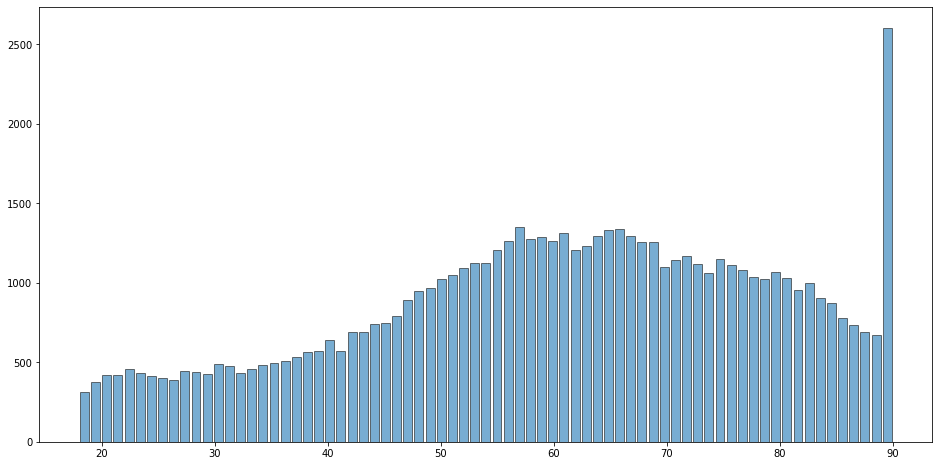

In [174]:
fig = plt.figure(figsize=(16,8))
_=plt.hist(df_grouped.age, bins=len(df_grouped.age.unique()), rwidth=0.8, ec='k', alpha=0.6)

Since there are patients with multiple records, let's see, what is the mean number of screening for each age.

In [175]:
avg_n = unique_df.loc[:,['id','age']].groupby('id').aggregate(lambda x: x.count())
avg_n

,age
id,
1,1
2,3
3,1
4,2
5,4
...,...
64533,2
64534,1
64535,1


Add decade column and compute mean and variance of the number of screenings for each decade.


In [176]:
df_grouped['n_records'] = avg_n
df_grouped['decade'] = (df_grouped.age // 10) * 10

In [177]:
df3 = df_grouped[['decade','n_records']].groupby('decade').aggregate('mean')
df3.columns = ['mean']
df4 = df_grouped[['decade','n_records']].groupby('decade').aggregate('var')
df4.columns = ['var']

In [178]:
df_grouped = df_grouped.join(df3, on='decade', lsuffix='_l').join(df4, on='decade', rsuffix='_r')

<Figure size 1440x720 with 0 Axes>

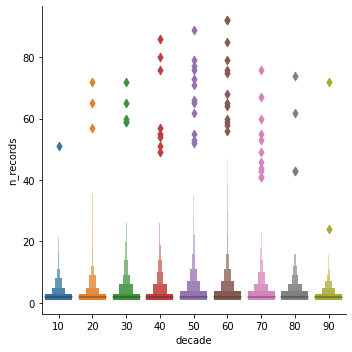

In [179]:
fig = plt.figure(figsize=(20,10))
#sns.boxplot(x='decade', y='n_records', data=df_grouped)
sns.catplot(x='decade', y='n_records', data=df_grouped, kind="boxen")

From now on we'll use the whole record table.

Pick relevant columns, i.e. columns which represent findings.

In [180]:
relevant_cols = df.columns[5:]
relevant_cols

Index(['no finding', 'enlarged cardiomediastinum', 'cardiomegaly',
       'lung opacity', 'lung lesion', 'edema', 'consolidation', 'pneumonia',
       'atelectasis', 'pneumothorax', 'pleural effusion', 'pleural other',
       'fracture', 'support devices'],
      dtype='object')

Replace -1 with 1.

In [181]:
dfv = df.loc[:,relevant_cols]
dfv = dfv.applymap(str)
dfv.head()

,no finding,enlarged cardiomediastinum,cardiomegaly,lung opacity,lung lesion,edema,consolidation,pneumonia,atelectasis,pneumothorax,pleural effusion,pleural other,fracture,support devices
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Count plot

In [182]:
a = dfv.stack()

In [183]:
a.index.names = ['id', 'finding']

In [184]:
a = a.reset_index(level=1,name='outcome')

In [185]:
a.head()

,finding,outcome
id,,
0,no finding,1.0
0,enlarged cardiomediastinum,0.0
0,cardiomegaly,0.0
0,lung opacity,0.0
0,lung lesion,0.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

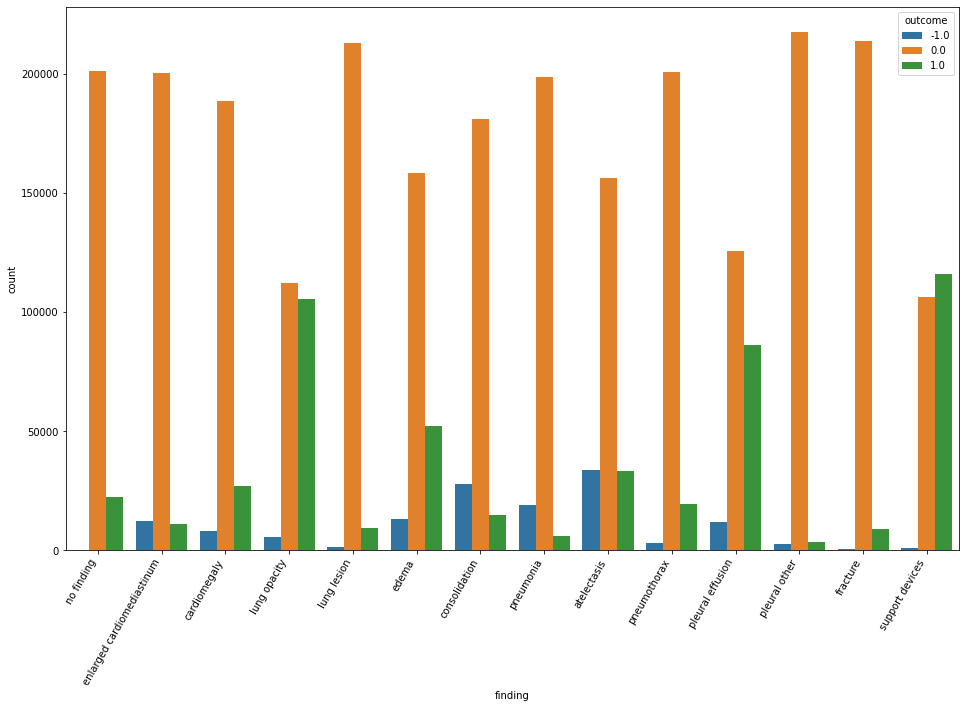

In [186]:
fig = plt.figure(figsize=(16,10))
sns.countplot(x='finding', hue='outcome', data=a)
plt.xticks(rotation=60, ha='right')

# Violin plot

In [187]:
dfv = df.loc[:, relevant_cols]

In [188]:
viodf = dfv.applymap(float)
viodf['age'] = df.age
viodf['sex'] = df.sex
viodf.head()

,no finding,enlarged cardiomediastinum,cardiomegaly,lung opacity,lung lesion,edema,consolidation,pneumonia,atelectasis,pneumothorax,pleural effusion,pleural other,fracture,support devices,age,sex
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68,Female
1,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,87,Female
2,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,83,Female
3,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,83,Female
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,Male


In [189]:
viodf.set_index(['age','sex'], inplace=True)
viodf.head()

no finding  enlarged cardiomediastinum  ...  fracture  support devices
age sex                                             ...                           
68  Female         1.0                         0.0  ...       0.0              1.0
87  Female         0.0                         0.0  ...       1.0              0.0
83  Female         0.0                         0.0  ...       1.0              0.0
    Female         0.0                         0.0  ...       1.0              0.0
41  Male           0.0                         0.0  ...       0.0              0.0

[5 rows x 14 columns]

In [190]:
stviodf=viodf.stack()
stviodf = stviodf[stviodf==1]
stviodf.index.names = ['age','sex','finding']
viodf = stviodf.reset_index(name='outcome')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

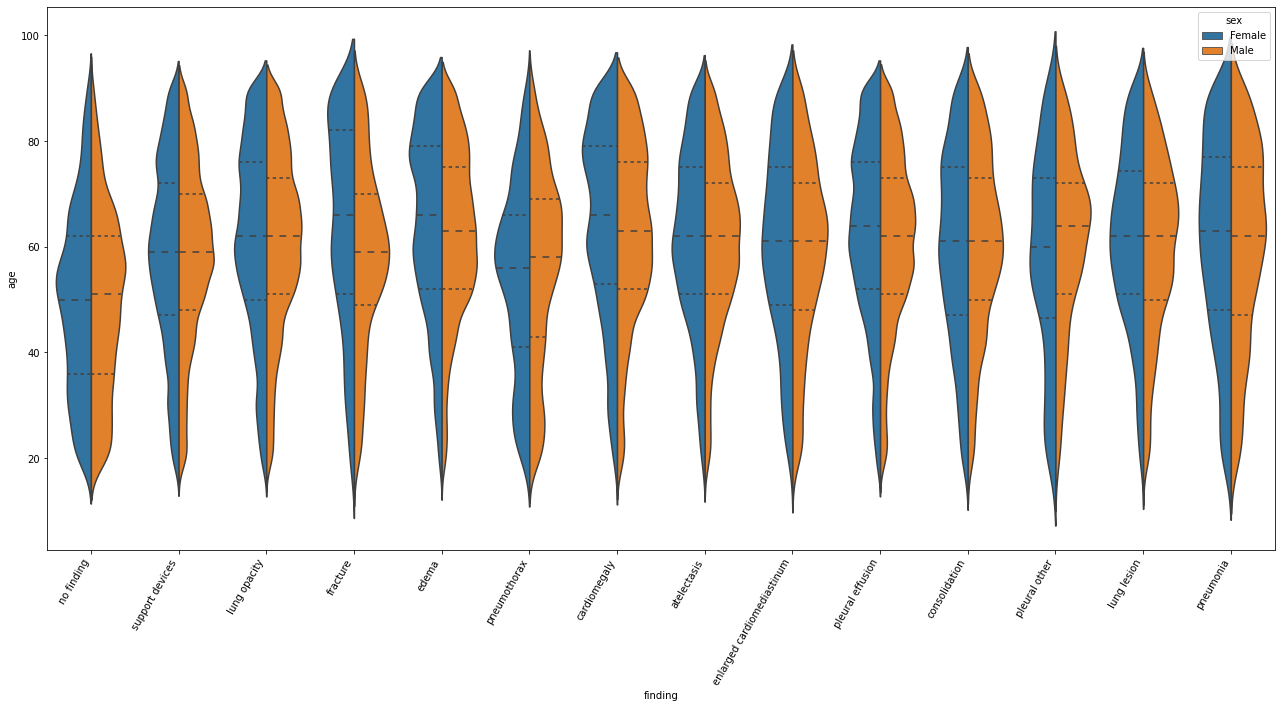

In [191]:
fig = plt.figure(figsize=(22,10))
sns.violinplot(x='finding', y='age', hue='sex', inner='quartile', split=True, data=viodf.iloc[:200000,:])
plt.xticks(rotation=60, ha='right')

# Age distribution for each disease

In [192]:
cols = list(df.columns[5:])
cols

['no finding',
 'enlarged cardiomediastinum',
 'cardiomegaly',
 'lung opacity',
 'lung lesion',
 'edema',
 'consolidation',
 'pneumonia',
 'atelectasis',
 'pneumothorax',
 'pleural effusion',
 'pleural other',
 'fracture',
 'support devices']

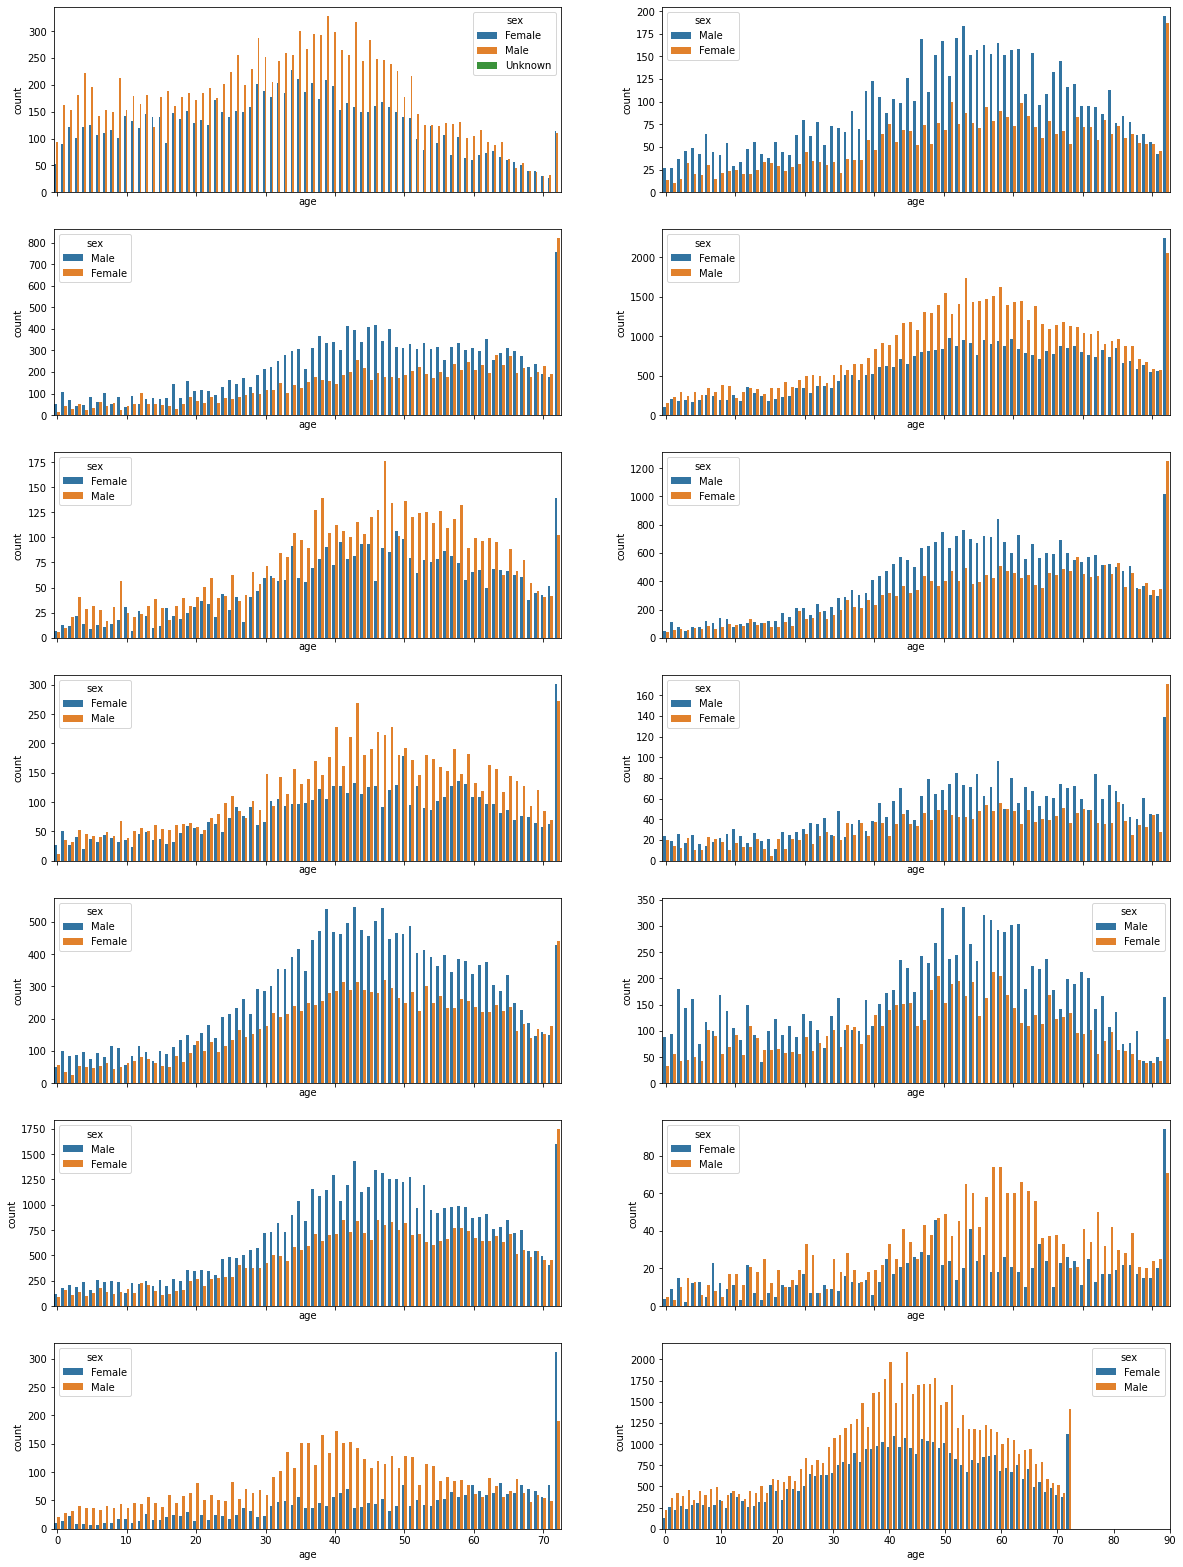

In [193]:
fig, ax = plt.subplots(7,2, sharex=True, figsize=(20,28))
x = np.arange(0,100,10)
for i,a in enumerate(ax.flatten()):
  sns.countplot(x='age',  hue='sex', data=df[df[cols[i]]==1] , ax=a)
  a.set_xticklabels(x)
  a.set_xticks(x)


In [194]:
diseases_df = df.iloc[:,6:]
diseases_df.replace(-1,0, inplace=True)

How many records have single and multiple pathologies?

In [195]:
single_df = diseases_df[diseases_df.sum(1) == 1]
single_df = single_df.stack().reset_index(level=1)
single_df.columns = ['finding', 'value']
single_df = single_df[single_df.value==1]

order = single_df.finding.value_counts().index

multiple_df = diseases_df[diseases_df.sum(1) > 1]
multiple_df = multiple_df.stack().reset_index(level=1)
multiple_df.columns = ['finding', 'value']
multiple_df = multiple_df[multiple_df.value==1]

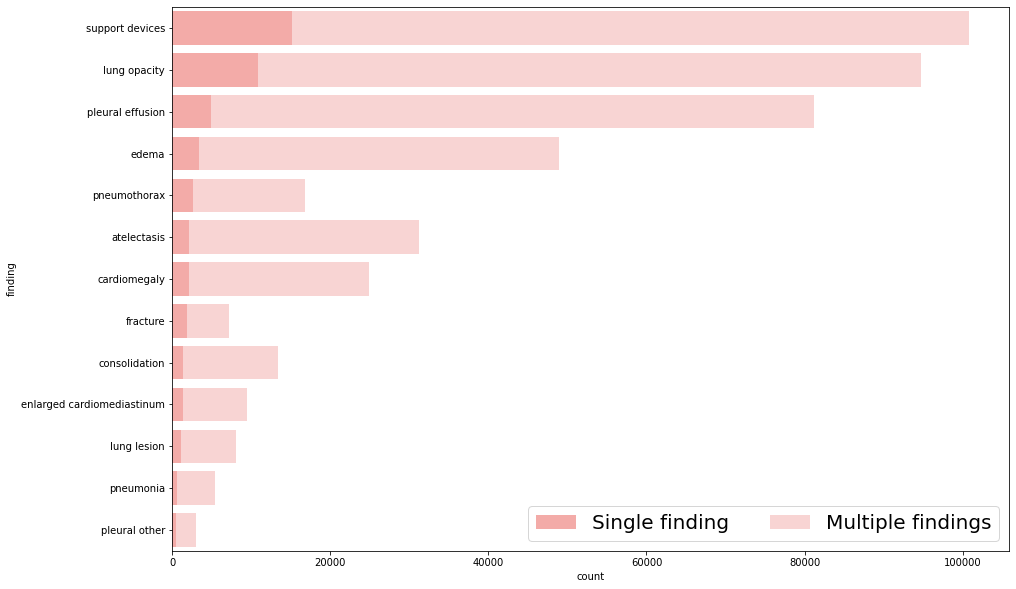

In [196]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))

sns.set_color_codes('pastel')
sns. countplot(y='finding', data=single_df, order=order, color='r', ax=ax)
sns. countplot(y='finding', data=multiple_df, color='r', order=order, ax=ax, alpha=0.5)
plt.legend(['Single finding','Multiple findings'], loc=4, ncol=2, fontsize=20)

# Plot pie chart with most common disease combinations

In [197]:
def f(d):
  s = ''
  for i in list(d.unique()):
    s += i +' / '
  return s[:-3]

Create Series object with disease combinations for each record.

In [198]:
res = multiple_df.groupby(by=multiple_df.index).aggregate(f)
res

,finding
1,lung opacity / fracture
2,lung opacity / fracture
3,lung opacity / fracture
12,cardiomegaly / lung opacity / atelectasis / pn...
13,enlarged cardiomediastinum / lung opacity / at...
...,...
223400,edema / support devices
223401,lung opacity / lung lesion / pneumothorax / pl...
223403,cardiomegaly / edema / pleural effusion / supp...
223407,edema / pleural effusion


In [199]:
groups = res.finding.value_counts()
groups.index.name='combo'
groups = groups.reset_index()
groups

,combo,finding
0,lung opacity / pleural effusion / support devices,13088
1,lung opacity / support devices,9649
2,lung opacity / pleural effusion,7219
3,lung opacity / edema / pleural effusion / supp...,6276
4,pleural effusion / support devices,4329
...,...,...
1445,enlarged cardiomediastinum / cardiomegaly / lu...,1
1446,enlarged cardiomediastinum / lung opacity / co...,1
1447,lung opacity / lung lesion / atelectasis / pne...,1
1448,cardiomegaly / atelectasis / pleural other,1


In [200]:
groups['freq'] = groups.finding / df.shape[0]

Pick 9 most frequent.

In [201]:
t1 = groups.iloc[9:,:].sum(0)
t1.iloc[0] = 'other'

g = groups.iloc[:9].append(t1, ignore_index=True)
g

,combo,finding,freq
0,lung opacity / pleural effusion / support devices,13088,0.058583
1,lung opacity / support devices,9649,0.043189
2,lung opacity / pleural effusion,7219,0.032313
3,lung opacity / edema / pleural effusion / supp...,6276,0.028092
4,pleural effusion / support devices,4329,0.019377
5,lung opacity / edema / support devices,4264,0.019086
6,edema / support devices,3775,0.016897
7,edema / pleural effusion / support devices,2690,0.012041
8,atelectasis / support devices,2620,0.011727
9,other,96776,0.433175


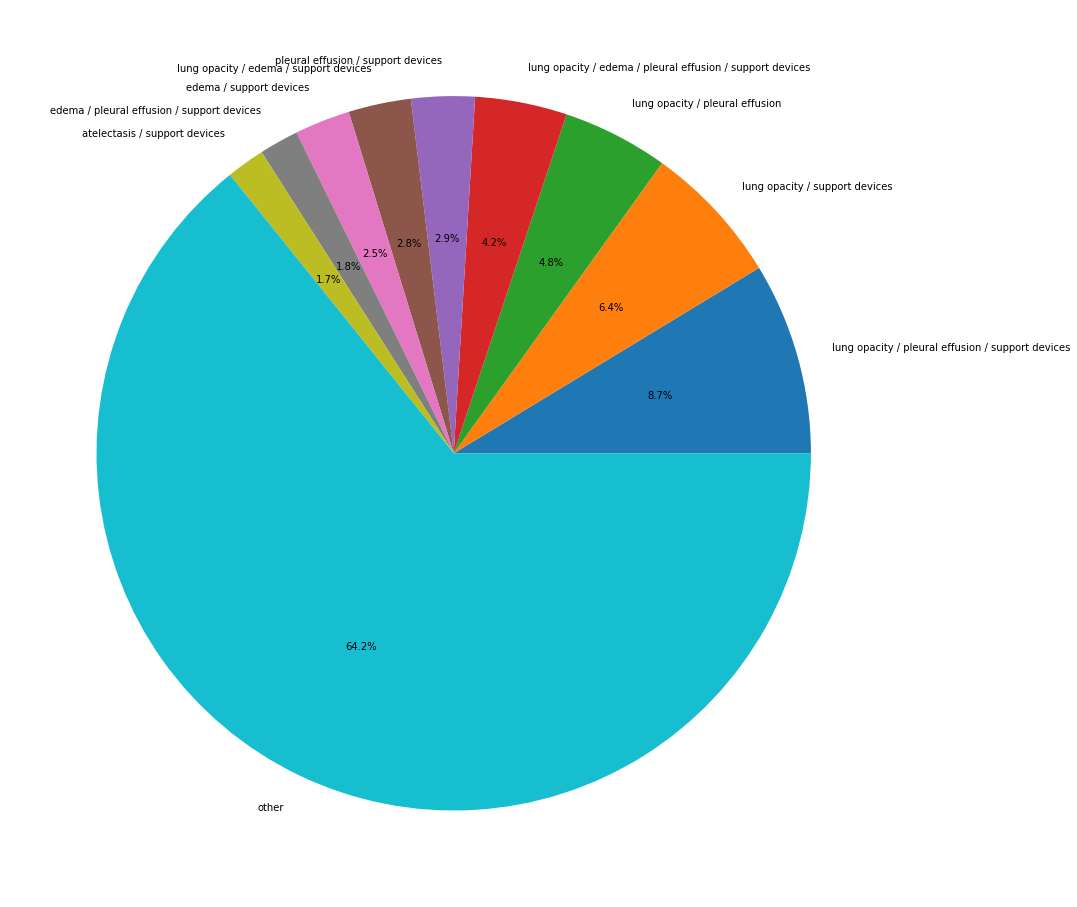

In [202]:
fig = plt.figure(figsize=(15,15))
plt.pie(x=g.finding, labels=g.combo, autopct='%1.1f%%')
plt.xticks(rotate=60, ha='left')
plt.tight_layout()